In [1]:
#!/usr/bin/env python3
import os
from os import path
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
outpath = "/home/dave/Documents/HRM/data/14-Feb-2019"
inpath = '/home/dave/Documents/HRM/data/14-Feb-2019/Wimeans_20190304T144722.txt'

In [2]:
time_series = pd.read_csv(inpath)
X, Y = time_series.shape
num_points = np.linspace(1, X+1, X+1, dtype = int)
columns = np.linspace(1, Y, Y, dtype = int)
time_series = pd.read_csv(inpath, names = columns)
[X, Y, num_points.shape, time_series.shape]

[568, 3465, (569,), (569, 3465)]

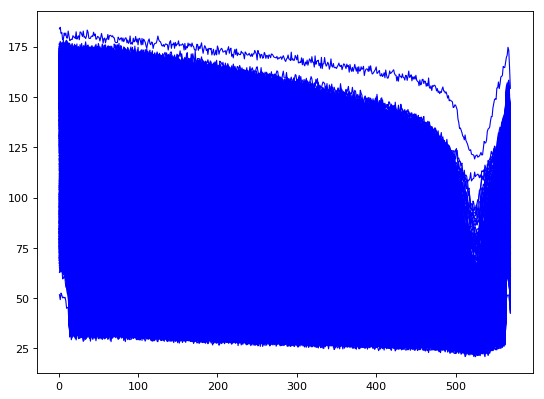

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
# Create a new subplot from a grid of 1x1
plt.subplot(1, 1, 1)

for i in range(1,Y+1):
    plt.plot(num_points, time_series[i], color="blue", linewidth=1.0, linestyle="-")

plt.show()

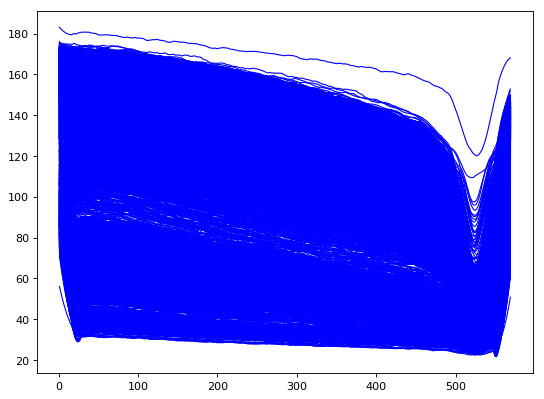

In [4]:
np.set_printoptions(precision=2)
plt.figure(figsize=(8, 6), dpi=80)
# Create a new subplot from a grid of 1x1
plt.subplot(1, 1, 1)

for i in range(1,Y+1):
    plt.plot(range(1,X+2), savgol_filter(time_series[i], 31, 2), color="blue", linewidth=1.0, linestyle="-")

plt.show()

In [5]:
diff_data = []

for i in range(1,Y+1):
    diff_data.append(-savgol_filter(np.diff(savgol_filter(time_series[i], 31, 2)), 5, 2))


<Figure size 640x480 with 0 Axes>

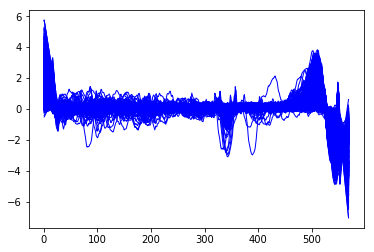

In [6]:
#columns = np.linspace(1, X-1, X-1, dtype = int)
diff_frame = pd.DataFrame(diff_data)
diff_frame_trans = diff_frame.T
plt.figure(figsize=(8, 6), dpi=80)
# Create a new subplot from a grid of 1x1
fig, ax = plt.subplots()

for i in range(1,Y):
    plt.plot(range(1,X+1), diff_frame_trans[i], color="blue", linewidth=1.0, linestyle="-")

plt.show()
fig.savefig(path.join(outpath,"Derivative_All_Plots.png"))

In [7]:
peaks = np.zeros((Y,1))
for i in range(0,Y):
    if diff_frame_trans[i].idxmax() > 475 and diff_frame_trans[i].idxmax() < 525 and diff_frame_trans[i].max() > 0.5:
        peaks[i, 0] = diff_frame_trans[i].idxmax()
    else:
        peaks[i, 0] = float('NaN')

/home/dave/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dave/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


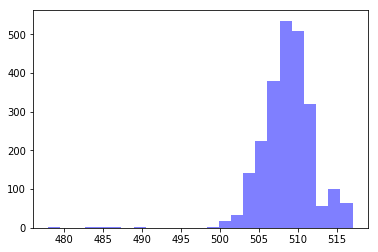

In [8]:
fig, ax = plt.subplots()
num_bins = 25
n, bins, patches = plt.hist(peaks, num_bins, facecolor='blue', alpha=0.5)
plt.show()
fig.savefig(path.join(outpath,"Peak_Histogram.png"))

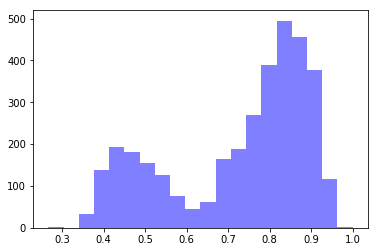

0.6741702741702742

In [9]:
fig, ax = plt.subplots()
num_bins = 20
n, bins, patches = plt.hist(time_series.T[1]/time_series.T[1].values.max(), num_bins, facecolor='blue', alpha=0.5)
plt.show()
fig.savefig(path.join(outpath,"Initial_Histogram.png"))
sum(i > 0.7 for i in time_series.T[1]/time_series.T[1].values.max())/len(time_series.T[1])

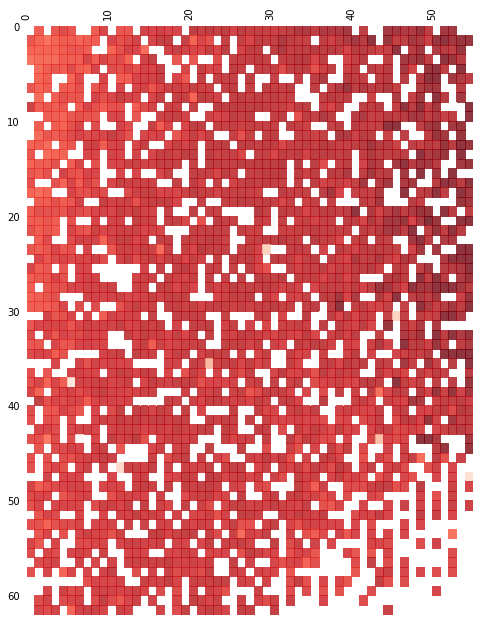

In [11]:
heatmap = np.reshape(peaks, (63,55)) #63,55 90,55

# Plot it out
fig, ax = plt.subplots()
heatmap = ax.pcolor(heatmap, cmap=plt.cm.Reds, alpha=0.8)

# Format
fig = plt.gcf()
fig.set_size_inches(8, 11)

# turn off the frame
ax.set_frame_on(False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# rotate the
plt.xticks(rotation=90)

ax.grid(False)

# Turn off all the ticks
ax = plt.gca()

for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False

fig.savefig(path.join(outpath,"heatmap.png"))

In [12]:
#Stats

#average value of peaks
peak_average = round(np.average(peaks[np.logical_not(np.isnan(peaks))]),2)
#STD value of peaks
peak_STD = round(np.std(peaks[np.logical_not(np.isnan(peaks))]),2)
#number of positive wells
percent_positive = round(len(peaks[np.logical_not(np.isnan(peaks))])/len(peaks),3)

[peak_average, peak_STD, percent_positive]

text_file = open("Stats.txt", "w")
text_file.write("The Average Peak occurs at %f" % peak_average)
text_file.write("\n The Standard deviation of the peaks is %f" % peak_STD)
text_file.write("\n The pecentage of wells determined to be positive is %f" % percent_positive)
text_file.close()